In [1]:
# importing all the necessary packages and data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Numerical computation package
from sklearn.neural_network import MLPRegressor # multilayer perceptron regressor and classifier
from sklearn.preprocessing import StandardScaler # helper to scale our data
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score

In [2]:
# important!! use index_col=0 to read df otherwise pca starts at col 58
ped = pd.read_csv("data_clean_with_dummies.csv", index_col=0)

# beginning of the code, so everyone has the same
np.random.seed(1) # Set the random seed for reproduceability


# Define a new X with the squared feature
X = np.array(ped[ped.columns[57:]])

# Output to predict
y = ped["pedestrians count"]


# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

In [3]:
# initialize the neural network to predict the pedestrians given our different features
# use three hidden layers, with sizes 32, 64, and 32, ReLU activation functions,
# stochastic gradient descent optimization and a regularization paramater
# (lambda or alpha) of 0.001, batchsizes of 32 and 1000 epochs
nnet = MLPRegressor(hidden_layer_sizes=(32, 64, 32), activation="relu", solver="sgd",
                    alpha=0.001, max_iter=1000)

In [4]:
# scale the data so it is less sensitive to feature scaling
scaler = StandardScaler()
# scale the inputs
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
# apply the same transformation to the test data to have meaningful results
Xtest = scaler.transform(Xtest)

# scale the y different because we can't use standardscaler to a 1d array
# scale the train output
mu_train, sigma_train = ytrain.mean(), ytrain.std() # We will use this to scale back to original values!
ytrain = (ytrain - mu_train) / sigma_train
# apply the same transformation to the test output
mu_test, sigma_test = ytest.mean(), ytest.std() # We will use this to scale back to original values!
ytest = (ytest - mu_test) / sigma_test

In [5]:
# Fit the network to the train data
nnet.fit(Xtrain, ytrain)

# Make predictions
ypred = nnet.predict(Xtest)

# Reconstruct outputs and scale predictions
ytest = ytest * sigma_test + mu_test
ypred = ypred * sigma_test + mu_test

# Compute the MAE
mae = np.sum(np.abs(ypred - ytest))
# Comute R^2
r2 = r2_score(ytest, ypred)

print(f"The mean absolute error is {mae}")
print(f"The R^2 is {r2}")

The mean absolute error is 2423704.9148250725
The R^2 is 0.928619546779347


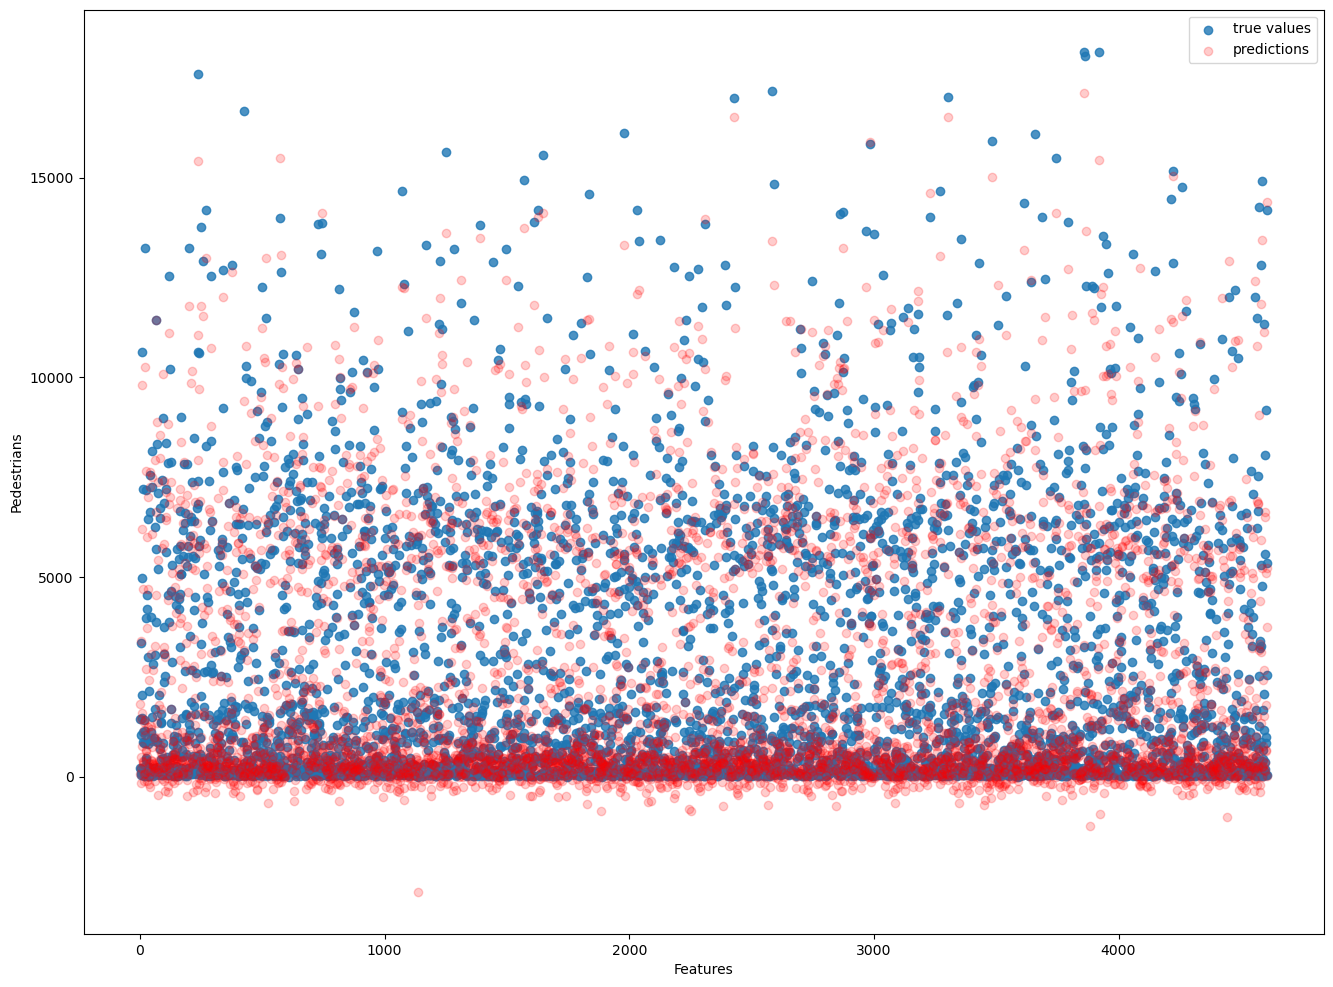

In [6]:
# plot the results
fig, ax = plt.subplots(figsize=(16, 12))

#create a linspace to match the y-values
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

# plot the true values for 2 pca variables
ax.scatter(xs, ytest, label="true values", alpha=0.8)

# plot the predictions
ax.scatter(xs, ypred, label="predictions", color = "red", alpha=0.2)

# Add labels and legend
ax.set_xlabel("Features")
ax.set_ylabel("Pedestrians")
ax.legend()

In [7]:
# scale the data so it is less sensitive to feature scaling
scaler = StandardScaler()
# scale the inputs
scaler.fit(X)
X = scaler.transform(X)

# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std() # We will use this to scale back to original values!
y = (y - mu) / sigma

# create custom scoring function
#def scorer(estimator, x, y):
    #ypred = estimator.predict(x)
    #mae = np.sum(np.abs(ypred - y))
    #r2 = r2_score(y, ypred)
    #return (mae, r2)

# create function to put in loop
#def train_and_test(hidden_layer, activation_function, solver, alpha, max_iteration):
    #nnet = MLPRegressor(hidden_layer_sizes=hidden_layer, activation=activation_function, solver=solver,
                    #alpha=alpha, max_iter=max_iteration) # optimization
    #scores = cross_val_score(nnet, X, y, cv=5, scoring="r2") # cross-validation and calculate r^2 within
    #print(scores)
    #nnet.fit(Xtrain, ytrain)
    #print(nnet.predict(Xtest))


#for hidden_layer in hidden_layers:
    #for activation_function in activation_functions:
        #for solver in solvers:
            #for alpha in alphas:
                #for max_iteration in max_iterations:
                    #train_and_test(hidden_layer, activation_function, solver, alpha, max_iteration)

# train_and_test((32, 64, 32), "relu", "sgd", 0.001, 1000)

In [8]:
scorers = ["r2", "neg_mean_absolute_error"]
parameters= {
    "hidden_layer_sizes": [(32, 64, 32), (64, 128, 64), (8, 16, 32, 16, 8), (32, 64, 128, 64, 32), (15, 27, 40, 31, 12)],
    "activation": ["relu", "logistic", "tanh", "identity"],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.0005, 0.00005],
    "max_iter": [1000, 2000]
}

model = GridSearchCV(MLPRegressor(), parameters, cv=5, scoring=scorers, refit=False)
model.fit(X, y)

results = pd.DataFrame()
params = model.cv_results_["params"]

maes = model.cv_results_["mean_test_neg_mean_absolute_error"]
r2s = model.cv_results_["mean_test_r2"]

results["Params"] = pd.Series(params)
results["MeanMAE"] = -pd.Series(maes)
results["MeanR2"] = pd.Series(r2s)

results.sort_values("MeanR2", inplace=True)

results.to_csv("results_nnet.csv", sep=";", index=False)

results

,Params,MeanMAE,MeanR2
91,"{'activation': 'logistic', 'alpha': 0.0005, 'h...",0.423645,-0.163528
72,"{'activation': 'logistic', 'alpha': 0.0001, 'h...",0.819121,-0.005044
74,"{'activation': 'logistic', 'alpha': 0.0001, 'h...",0.818322,-0.004829
116,"{'activation': 'logistic', 'alpha': 5e-05, 'hi...",0.817289,-0.004823
94,"{'activation': 'logistic', 'alpha': 0.0005, 'h...",0.815178,-0.004760
...,...,...,...
166,"{'activation': 'tanh', 'alpha': 5e-05, 'hidden...",0.201896,0.886856
178,"{'activation': 'tanh', 'alpha': 5e-05, 'hidden...",0.188204,0.890093
174,"{'activation': 'tanh', 'alpha': 5e-05, 'hidden...",0.185793,0.890601
144,"{'activation': 'tanh', 'alpha': 0.0005, 'hidde...",0.196453,0.891219
